# Anytown GNN 
#### Version: 2
#### Branch: GNN-v2

## Import

In [1]:
import wntr
import pandas as pd
import numpy as np
import pickle
import networkx as nx

import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import convert
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.datasets import Planetoid


C:\Programs\Anaconda3\envs\PyTorch_Env\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


## Load inp(s) into graphs

(<matplotlib.collections.PathCollection at 0x2deb5a19400>,
 <matplotlib.collections.LineCollection at 0x2deb59f27c0>)

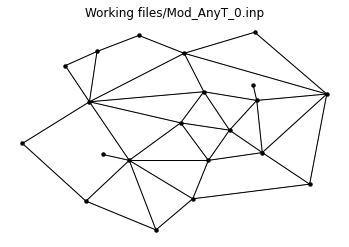

In [2]:
# Create a water network model
inp_file = 'Working files/Mod_AnyT_0.inp'
wn_current_WDS = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn_current_WDS, title=wn_current_WDS.name)


In [3]:
demands=[]
for i in wn_current_WDS.node_name_list:
    a = wn_current_WDS.get_node(i)
    try:
        demands.append(a.base_demand)
    except Exception as e:
        demands.append(-a.base_head)  #demands.append(0)
        print(e)


'Reservoir' object has no attribute 'base_demand'
'Reservoir' object has no attribute 'base_demand'


In [4]:
demands

[0.0315450982,
 0.01261803928,
 0.01261803928,
 0.01261803928,
 0.0,
 0.0315450982,
 0.0315450982,
 0.0,
 0.0315450982,
 0.0630901964,
 0.0315450982,
 0.0315450982,
 0.0,
 0.01261803928,
 0.01261803928,
 0.01261803928,
 0.01261803928,
 0.05047215712,
 0.01261803928,
 -65.532,
 -65.532]

In [5]:
a = wn_current_WDS.get_link(20)

In [6]:
lengths_pipes=[]
for i in wn_current_WDS.link_name_list:
    a = wn_current_WDS.get_link(i)
#     try:
    lengths_pipes.append(a.length)
#     except Exception as e:
#     lengths_pipes.append(-a.base_head)  #demands.append(0)
#     print(e)

In [7]:
num_pipes = len(lengths_pipes)

In [8]:
G_WDS = wn_current_WDS.get_graph() # directed multigraph

In [9]:
uG_WDS = G_WDS.to_undirected()

In [10]:
sG_WDS = nx.Graph(G_WDS)
type(sG_WDS)

networkx.classes.graph.Graph

In [11]:
sG_WDS.nodes

NodeView(('20', '30', '40', '50', '55', '60', '70', '75', '80', '90', '100', '110', '115', '120', '130', '140', '150', '160', '170', '65', '165'))

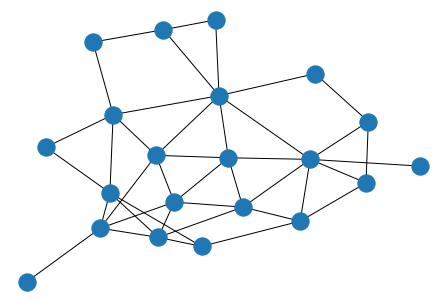

In [12]:
nx.draw(sG_WDS)

In [13]:
pg_sG_WDS = convert.from_networkx(sG_WDS)

In [14]:
pg_sG_WDS

Data(edge_index=[2, 80], pos=[21, 2], type=[80])

In [15]:
database = pickle.load( open( "Mod_AnyT_DB_trial.p", "rb" ) )

#data_list = [Data(...), ..., Data(...)]
#loader = DataLoader(data_list, batch_size=32)

In [16]:
NUM_GRAPHS = 100

In [17]:
diams_matrix = np.array([np.array(xi).T for xi in database['Diams']]).reshape(NUM_GRAPHS, num_pipes)

In [18]:
diams_matrix.shape

(100, 40)

### List of Data (graphs)

In [19]:
graphs = []

for i in range(len(diams_matrix)):
    curr_graph = pg_sG_WDS.clone()

    curr_graph.demands = torch.tensor(demands).reshape([len(demands),1])
    curr_graph.lengths = torch.tensor(lengths_pipes).reshape([len(lengths_pipes), 1])
    curr_graph.diams = torch.tensor(np.concatenate([diams_matrix[i],diams_matrix[i]])).reshape([2*len(diams_matrix[i]),1])
    curr_graph.res_index = torch.tensor(np.array(database['avgPrPa'][i])).reshape([1,1])
    

    graphs.append(curr_graph)



In [20]:
graphs[0:5]

[Data(demands=[21, 1], diams=[80, 1], edge_index=[2, 80], lengths=[40, 1], pos=[21, 2], res_index=[1, 1], type=[80]),
 Data(demands=[21, 1], diams=[80, 1], edge_index=[2, 80], lengths=[40, 1], pos=[21, 2], res_index=[1, 1], type=[80]),
 Data(demands=[21, 1], diams=[80, 1], edge_index=[2, 80], lengths=[40, 1], pos=[21, 2], res_index=[1, 1], type=[80]),
 Data(demands=[21, 1], diams=[80, 1], edge_index=[2, 80], lengths=[40, 1], pos=[21, 2], res_index=[1, 1], type=[80]),
 Data(demands=[21, 1], diams=[80, 1], edge_index=[2, 80], lengths=[40, 1], pos=[21, 2], res_index=[1, 1], type=[80])]

In [21]:
data = graphs[0]

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
# print(f'Is undirected: {data.is_undirected()}')

Number of nodes: 21
Number of edges: 80
Average node degree: 3.81
Contains isolated nodes: False
Contains self-loops: False


In [22]:
#Training and testing DataLoaders

train_loader = DataLoader(graphs[0:70], batch_size=10, shuffle=True)
test_loader = DataLoader(graphs[70:99], batch_size=10, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 10
Batch(batch=[210], demands=[210, 1], diams=[800, 1], edge_index=[2, 800], lengths=[400, 1], pos=[210, 2], res_index=[1, 10], type=[10])

Step 2:
Number of graphs in the current batch: 10
Batch(batch=[210], demands=[210, 1], diams=[800, 1], edge_index=[2, 800], lengths=[400, 1], pos=[210, 2], res_index=[1, 10], type=[10])

Step 3:
Number of graphs in the current batch: 10
Batch(batch=[210], demands=[210, 1], diams=[800, 1], edge_index=[2, 800], lengths=[400, 1], pos=[210, 2], res_index=[1, 10], type=[10])

Step 4:
Number of graphs in the current batch: 10
Batch(batch=[210], demands=[210, 1], diams=[800, 1], edge_index=[2, 800], lengths=[400, 1], pos=[210, 2], res_index=[1, 10], type=[10])

Step 5:
Number of graphs in the current batch: 10
Batch(batch=[210], demands=[210, 1], diams=[800, 1], edge_index=[2, 800], lengths=[400, 1], pos=[210, 2], res_index=[1, 10], type=[10])

Step 6:
Number of graphs in the current batch: 10
Batch(batch=[21

### Old Graph Neural Network Model - Node classification

In [23]:
# class GNN_v1(torch.nn.Module):
#     def __init__(self):
#         super(GNN_v1, self).__init__()
        
#         self.conv1 = GCNConv(40, 10) #number of features : 10
#         self.conv2 = GCNConv(10, 1) # 10 : number of classes (It's Regression, so only one number)

#     def forward(self, data):
#         x, edge_index = data.diams_x, data.edge_index

#         x = self.conv1(x, edge_index)
#         x = F.relu(x)
#         x = F.dropout(x, training=self.training)
#         x = self.conv2(x, edge_index)

#         return torch.sigmoid(x)

In [24]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = Net().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


In [25]:
# model.train()
# model.double()
# for epoch in range(240):
#     optimizer.zero_grad()
#     out = model(pg_sG_WDS)
#     loss = F.mse_loss(out[pg_sG_WDS.train_mask], pg_sG_WDS.res_index[pg_sG_WDS.train_mask])
#     if epoch%20==0:
#         print(loss)
#     loss.backward()
#     optimizer.step()

In [26]:
# model.eval()
# pred = model(pg_sG_WDS)
# # correct = int(pred[pg_sG_WDS.test_mask].eq(data.y[data.test_mask]).sum().item())
# # acc = correct / int(data.test_mask.sum())
# # print('Accuracy: {:.4f}'.format(acc))

### New GNN - Graph regression

In [ ]:
for i in train_loader:
    print(i)

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(210, hidden_channels)
        self.conv2 = GCNConv(hidden_channels,hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, 1)

    def forward(self, data):
        
        x, edge_index, batch = data.demands, data.edge_index, data.batch
        #x = x.reshape([21, 10])
        
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x
    
model = GCN(hidden_channels=30)
print(model)

In [ ]:
model = GCN(hidden_channels=10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

def train():
    model.train()
    
    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data)  # Perform a single forward pass.
         loss = criterion(out, data.res_index)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

            
def test(loader):
     model.eval()

     #correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 201):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

#### Branch GNN v2

In [ ]:
a = graphs[0].demands.clone()

In [ ]:
a

## New attempt (in my way)

Data

In [27]:
graphs

[Data(demands=[21, 1], diams=[80, 1], edge_index=[2, 80], lengths=[40, 1], pos=[21, 2], res_index=[1, 1], type=[80]),
 Data(demands=[21, 1], diams=[80, 1], edge_index=[2, 80], lengths=[40, 1], pos=[21, 2], res_index=[1, 1], type=[80]),
 Data(demands=[21, 1], diams=[80, 1], edge_index=[2, 80], lengths=[40, 1], pos=[21, 2], res_index=[1, 1], type=[80]),
 Data(demands=[21, 1], diams=[80, 1], edge_index=[2, 80], lengths=[40, 1], pos=[21, 2], res_index=[1, 1], type=[80]),
 Data(demands=[21, 1], diams=[80, 1], edge_index=[2, 80], lengths=[40, 1], pos=[21, 2], res_index=[1, 1], type=[80]),
 Data(demands=[21, 1], diams=[80, 1], edge_index=[2, 80], lengths=[40, 1], pos=[21, 2], res_index=[1, 1], type=[80]),
 Data(demands=[21, 1], diams=[80, 1], edge_index=[2, 80], lengths=[40, 1], pos=[21, 2], res_index=[1, 1], type=[80]),
 Data(demands=[21, 1], diams=[80, 1], edge_index=[2, 80], lengths=[40, 1], pos=[21, 2], res_index=[1, 1], type=[80]),
 Data(demands=[21, 1], diams=[80, 1], edge_index=[2, 80]

Model

In [28]:
class myGNN(torch.nn.Module):
    def __init__(self):
        super(myGNN, self).__init__()
        
        self.conv1 = GCNConv(21, 10) #number of features : 21
        self.conv2 = GCNConv(10, 1) # 10 : number of classes (It's Regression, so only one number)

    def forward(self, data):
        x, edge_index = data.demands, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return torch.sigmoid(x)

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = myGNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [30]:
model.train()
model.double()
for graph in graphs:
    optimizer.zero_grad()
    out = model(graph)
    loss = F.mse_loss(out, graph.res_index)
    if epoch%20==0:
        print(loss)
    loss.backward()
    optimizer.step()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (21x1 and 21x10)

In [ ]:
class SuperModel(nn.Module):
    def __init__(self):
        super(SuperModel, self).__init__()
        
        self.weight = nn.Parameter(torch.tensor(10.))
        self.bias = nn.Parameter(torch.tensor(5.))

        #self.reset_parameters()
        
#         self.slope = torch.tensor([10.], requires_grad=True)
#         self.bias = torch.tensor([5.], requires_grad=True)
    
    def forward(self, x):
        return x*self.weight + self.bias